In [40]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

print(tf.__version__)

2.10.0


In [41]:
def set_random_seed(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)  # Add this line for TensorFlow
    # torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

set_random_seed(7777)

In [42]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                64        
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


In [43]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [44]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)

    # Initial condition
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u,t)

    # Loss
    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one
    
    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [45]:
# train_t = (np.array([0., 0.025, 0.475, 0.5, 0.525, 0.9, 0.95, 1., 1.05, 1.1, 1.4, 1.45, 1.5, 1.55, 1.6, 1.95, 2.])).reshape(-1, 1)
train_t = (np.array([0., 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1., 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.])).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optim.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())


1.5586022
0.0017287864
0.0005080141
0.0001987415
0.000118241674
3.9243365e-05


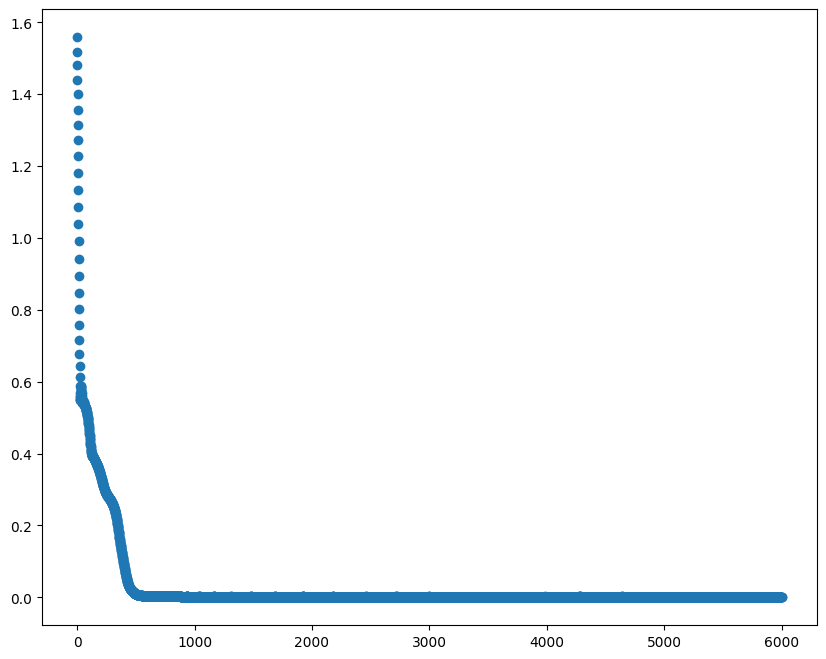

In [46]:
plt.figure(figsize=(10,8))
plt.plot(train_loss_record, 'o')
plt.show()

In [47]:
test_t = np.linspace(0,2,100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

4/4 [==============================] - 0s 678us/step


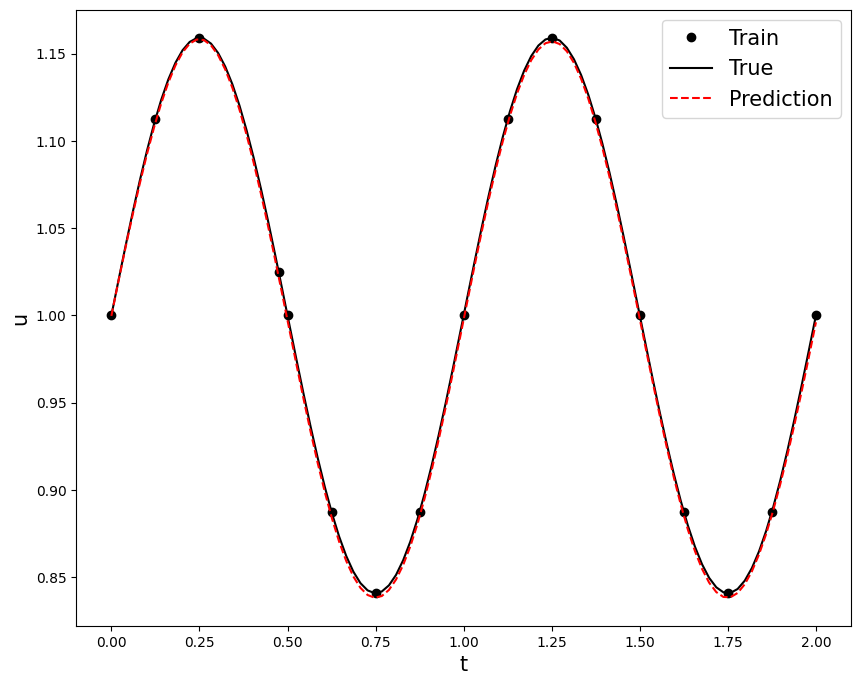

In [48]:
plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()